In [ ]:
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv("fake.csv.zip")


In [ ]:
print("Initial dataset shape:", df.shape)


Initial dataset shape: (12999, 20)


In [ ]:
df = df[['title', 'text', 'type']]
print("Columns used:", df.columns.tolist())
print("Shape after column selection:", df.shape)


Columns used: ['title', 'text', 'type']
Shape after column selection: (12999, 3)


In [ ]:
df.dropna(inplace=True)
print("Shape after removing NaN values:", df.shape)


Shape after removing NaN values: (12273, 3)


In [ ]:
df['content'] = df['title'] + " " + df['text']
print("Sample combined text:\n", df['content'].iloc[0][:300])


Sample combined text:
 Muslims BUSTED: They Stole Millions In Gov’t Benefits Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? 
Here we go again …another group stealing from the government a


In [ ]:
X = df['content']
y = df['type']
print("Number of samples:", len(X))
print("Number of labels:", len(y))

print("Class distribution:")
print(y.value_counts())

print("\nClass distribution (%):")
print(y.value_counts(normalize=True) * 100)


Number of samples: 12273
Number of labels: 12273
Class distribution:
type
bs            10919
conspiracy      412
bias            354
hate            246
state           121
junksci         102
satire          100
fake             19
Name: count, dtype: int64

Class distribution (%):
type
bs            88.967653
conspiracy     3.356962
bias           2.884380
hate           2.004400
state          0.985904
junksci        0.831093
satire         0.814797
fake           0.154811
Name: proportion, dtype: float64


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=2/3,
    stratify=y_temp,
    random_state=42
)
print("Training size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))


Training size: 8591
Validation size: 1227
Test size: 2455


In [ ]:
print("\nTraining class distribution:")
print(y_train.value_counts())

print("\nValidation class distribution:")
print(y_val.value_counts())

print("\nTest class distribution:")
print(y_test.value_counts())



Training class distribution:
type
bs            7643
conspiracy     288
bias           248
hate           172
state           85
junksci         72
satire          70
fake            13
Name: count, dtype: int64

Validation class distribution:
type
bs            1092
conspiracy      41
bias            35
hate            25
state           12
junksci         10
satire          10
fake             2
Name: count, dtype: int64

Test class distribution:
type
bs            2184
conspiracy      83
bias            71
hate            49
state           24
satire          20
junksci         20
fake             4
Name: count, dtype: int64


In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return " ".join(tokens)


In [ ]:
X_train = X_train.apply(clean_text)
X_val   = X_val.apply(clean_text)
X_test  = X_test.apply(clean_text)


In [ ]:
print("Before cleaning:\n", df['content'].iloc[0][:300])
print("\nAfter cleaning:\n", X_train.iloc[0][:300])


Before cleaning:
 Muslims BUSTED: They Stole Millions In Gov’t Benefits Print They should pay all the back all the money plus interest. The entire family and everyone who came in with them need to be deported asap. Why did it take two years to bust them? 
Here we go again …another group stealing from the government a

After cleaning:
 donald trump likely end aid rebels fighting syrian government information donald trump likely end aid rebels fighting syrian government david e sanger november nyt washington presidentelect donald j trump said friday likely abandon american effort support moderate opposition groups syria battling go


In [ ]:
print("Empty docs in training:", (X_train == "").sum())
print("Empty docs in validation:", (X_val == "").sum())
print("Empty docs in test:", (X_test == "").sum())


Empty docs in training: 41
Empty docs in validation: 4
Empty docs in test: 14


In [ ]:
# Training
mask = X_train.str.strip() != ""
X_train = X_train[mask]
y_train = y_train[mask]

# Validation
mask = X_val.str.strip() != ""
X_val = X_val[mask]
y_val = y_val[mask]

# Test
mask = X_test.str.strip() != ""
X_test = X_test[mask]
y_test = y_test[mask]


In [ ]:
print("Empty docs after removal (train):", (X_train == "").sum())
print("Final training size:", len(X_train))


Empty docs after removal (train): 0
Final training size: 8550


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight


In [ ]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=20000,
    min_df=5
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)


In [ ]:
print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF validation shape:", X_val_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)


TF-IDF train shape: (8550, 20000)
TF-IDF validation shape: (1223, 20000)
TF-IDF test shape: (2441, 20000)


In [ ]:
import numpy as np

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, weights))


In [ ]:
print("Class weights:")
for k, v in class_weight_dict.items():
    print(f"{k}: {v:.3f}")


Class weights:
bias: 4.309
bs: 0.141
conspiracy: 3.711
fake: 82.212
hate: 6.214
junksci: 14.844
satire: 15.268
state: 12.574


In [ ]:
lr = LogisticRegression(
    max_iter=1000,
    class_weight=class_weight_dict
)

lr.fit(X_train_tfidf, y_train)
print("Logistic Regression training completed")


Logistic Regression training completed


In [ ]:
svm = LinearSVC(
    class_weight=class_weight_dict
)

svm.fit(X_train_tfidf, y_train)
print("SVM training completed")


SVM training completed


In [ ]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
print("Naïve Bayes training completed")


Naïve Bayes training completed


In [ ]:
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight=class_weight_dict,
    random_state=42
)

rf.fit(X_train_tfidf, y_train)
print("Random Forest training completed")


Random Forest training completed


In [ ]:
models = {
    "Logistic Regression": lr,
    "SVM": svm,
    "Naive Bayes": nb,
    "Random Forest": rf
}

print("Total models trained:", len(models))


Total models trained: 4


In [ ]:
from sklearn.metrics import accuracy_score

for name, model in models.items():
    y_val_pred = model.predict(X_val_tfidf)
    acc = accuracy_score(y_val, y_val_pred)
    print(f"{name} | Validation Accuracy: {acc:.4f}")


Logistic Regression | Validation Accuracy: 0.8316
SVM | Validation Accuracy: 0.9199
Naive Bayes | Validation Accuracy: 0.8888
Random Forest | Validation Accuracy: 0.9092


In [ ]:
print("\nFINAL COMPARISON TABLE")
print(results_df)



results_df.to_csv("final_model_results.csv", index=False)



FINAL COMPARISON TABLE
                 Model  Accuracy  Macro Precision  Macro Recall  Macro F1
0  Logistic Regression  0.824662         0.411259      0.577264  0.455470
1                  SVM  0.921344         0.676485      0.433444  0.507093
2          Naive Bayes  0.886932         0.259853      0.137063  0.140309
3        Random Forest  0.909054         0.827277      0.239108  0.305581


In [ ]:
import matplotlib.pyplot as plt


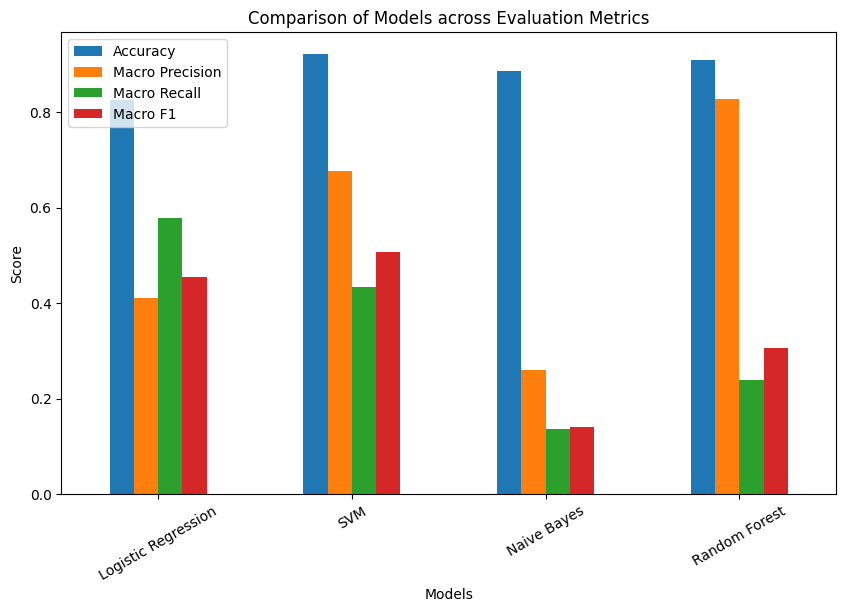

In [ ]:
results_df.set_index('Model')[['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1']].plot(
    kind='bar',
    figsize=(10,6)
)

plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Comparison of Models across Evaluation Metrics")
plt.xticks(rotation=30)
plt.legend()
plt.show()


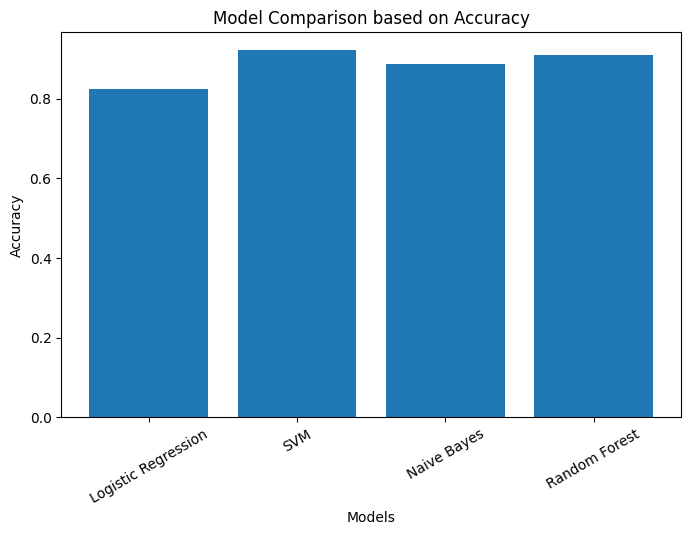

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['Accuracy'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Comparison based on Accuracy")
plt.xticks(rotation=30)
plt.show()


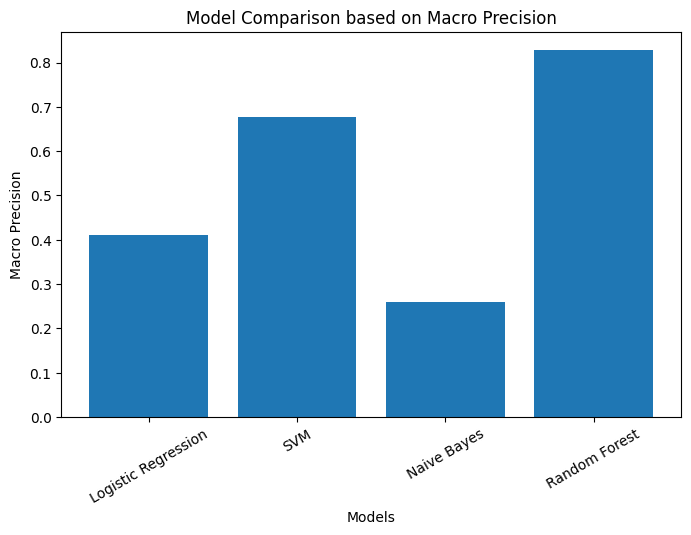

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['Macro Precision'])
plt.xlabel("Models")
plt.ylabel("Macro Precision")
plt.title("Model Comparison based on Macro Precision")
plt.xticks(rotation=30)
plt.show()


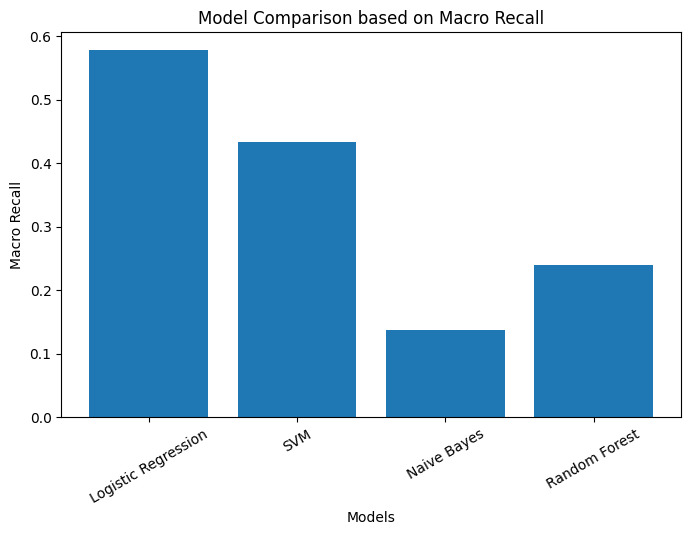

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['Macro Recall'])
plt.xlabel("Models")
plt.ylabel("Macro Recall")
plt.title("Model Comparison based on Macro Recall")
plt.xticks(rotation=30)
plt.show()


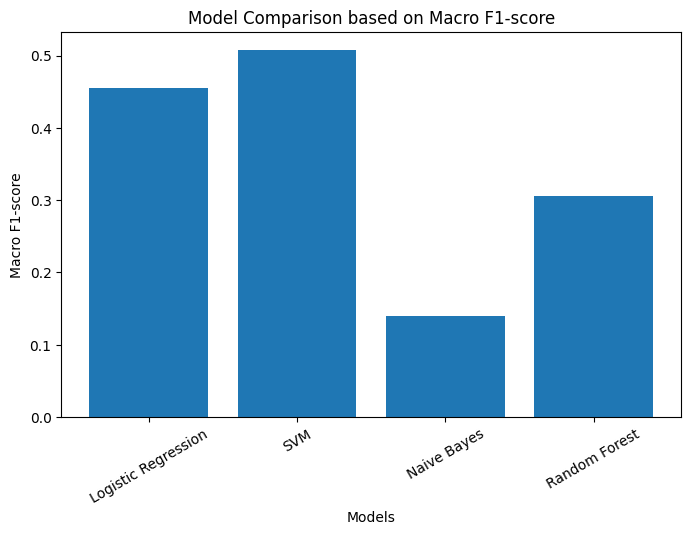

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(results_df['Model'], results_df['Macro F1'])
plt.xlabel("Models")
plt.ylabel("Macro F1-score")
plt.title("Model Comparison based on Macro F1-score")
plt.xticks(rotation=30)
plt.show()


In [ ]:
y_pred = model.predict(X_test_tfidf)


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)


In [ ]:
import numpy as np

cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)


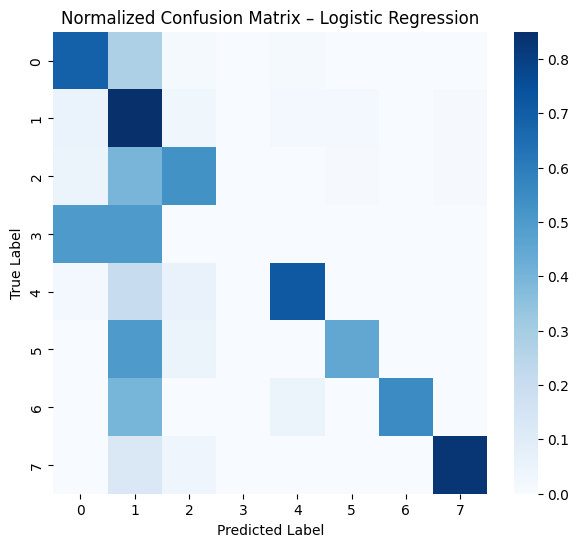

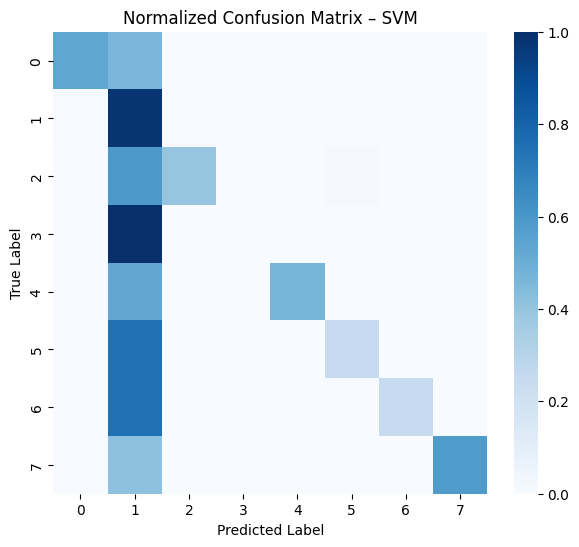

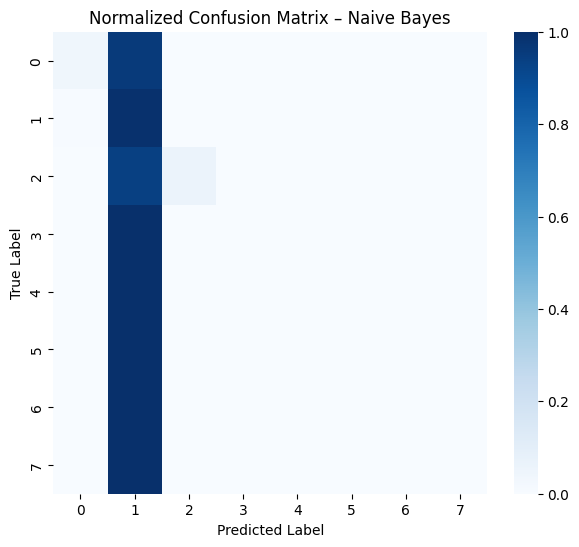

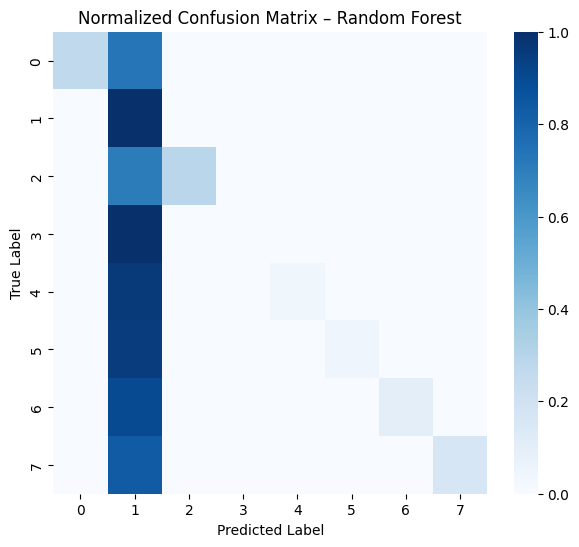

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(7,6))
    sns.heatmap(cm_norm, cmap="Blues")
    plt.title(f"Normalized Confusion Matrix – {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()



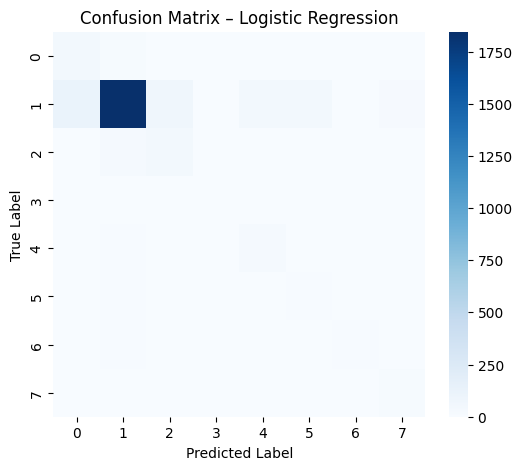

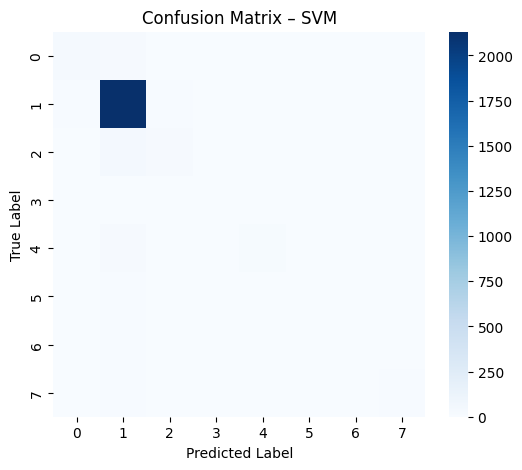

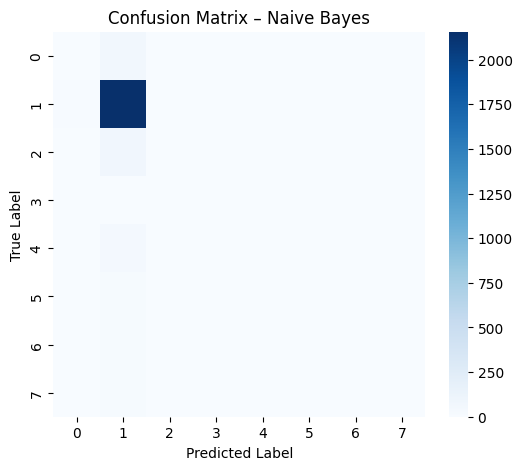

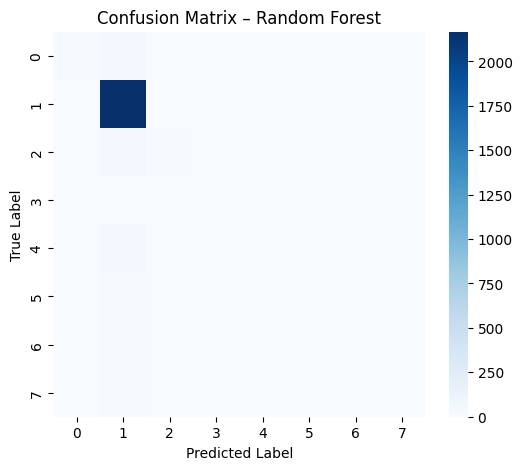

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, cmap="Blues", annot=False)
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


In [ ]:
best_model_name = results_df.loc[results_df["Macro F1"].idxmax(), "Model"]
best_f1 = results_df["Macro F1"].max()

print("Best model selected based on Macro F1-score:")
print("Best Model :", best_model_name)
print("Macro F1   :", round(best_f1, 4))


Best model selected based on Macro F1-score:
Best Model : SVM
Macro F1   : 0.5071


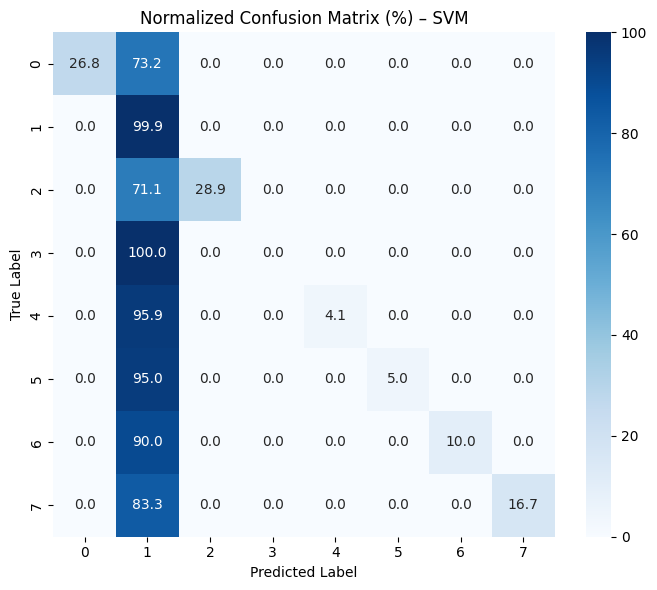

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
sns.heatmap(cm_normalized * 100, cmap="Blues", annot=True, fmt=".1f")
plt.title(f"Normalized Confusion Matrix (%) – {best_model_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
